In [3]:
import numpy as np
from scipy.stats import bootstrap
import pandas as pd
import glob
from collections import defaultdict
import typing
import matplotlib.pyplot as plt

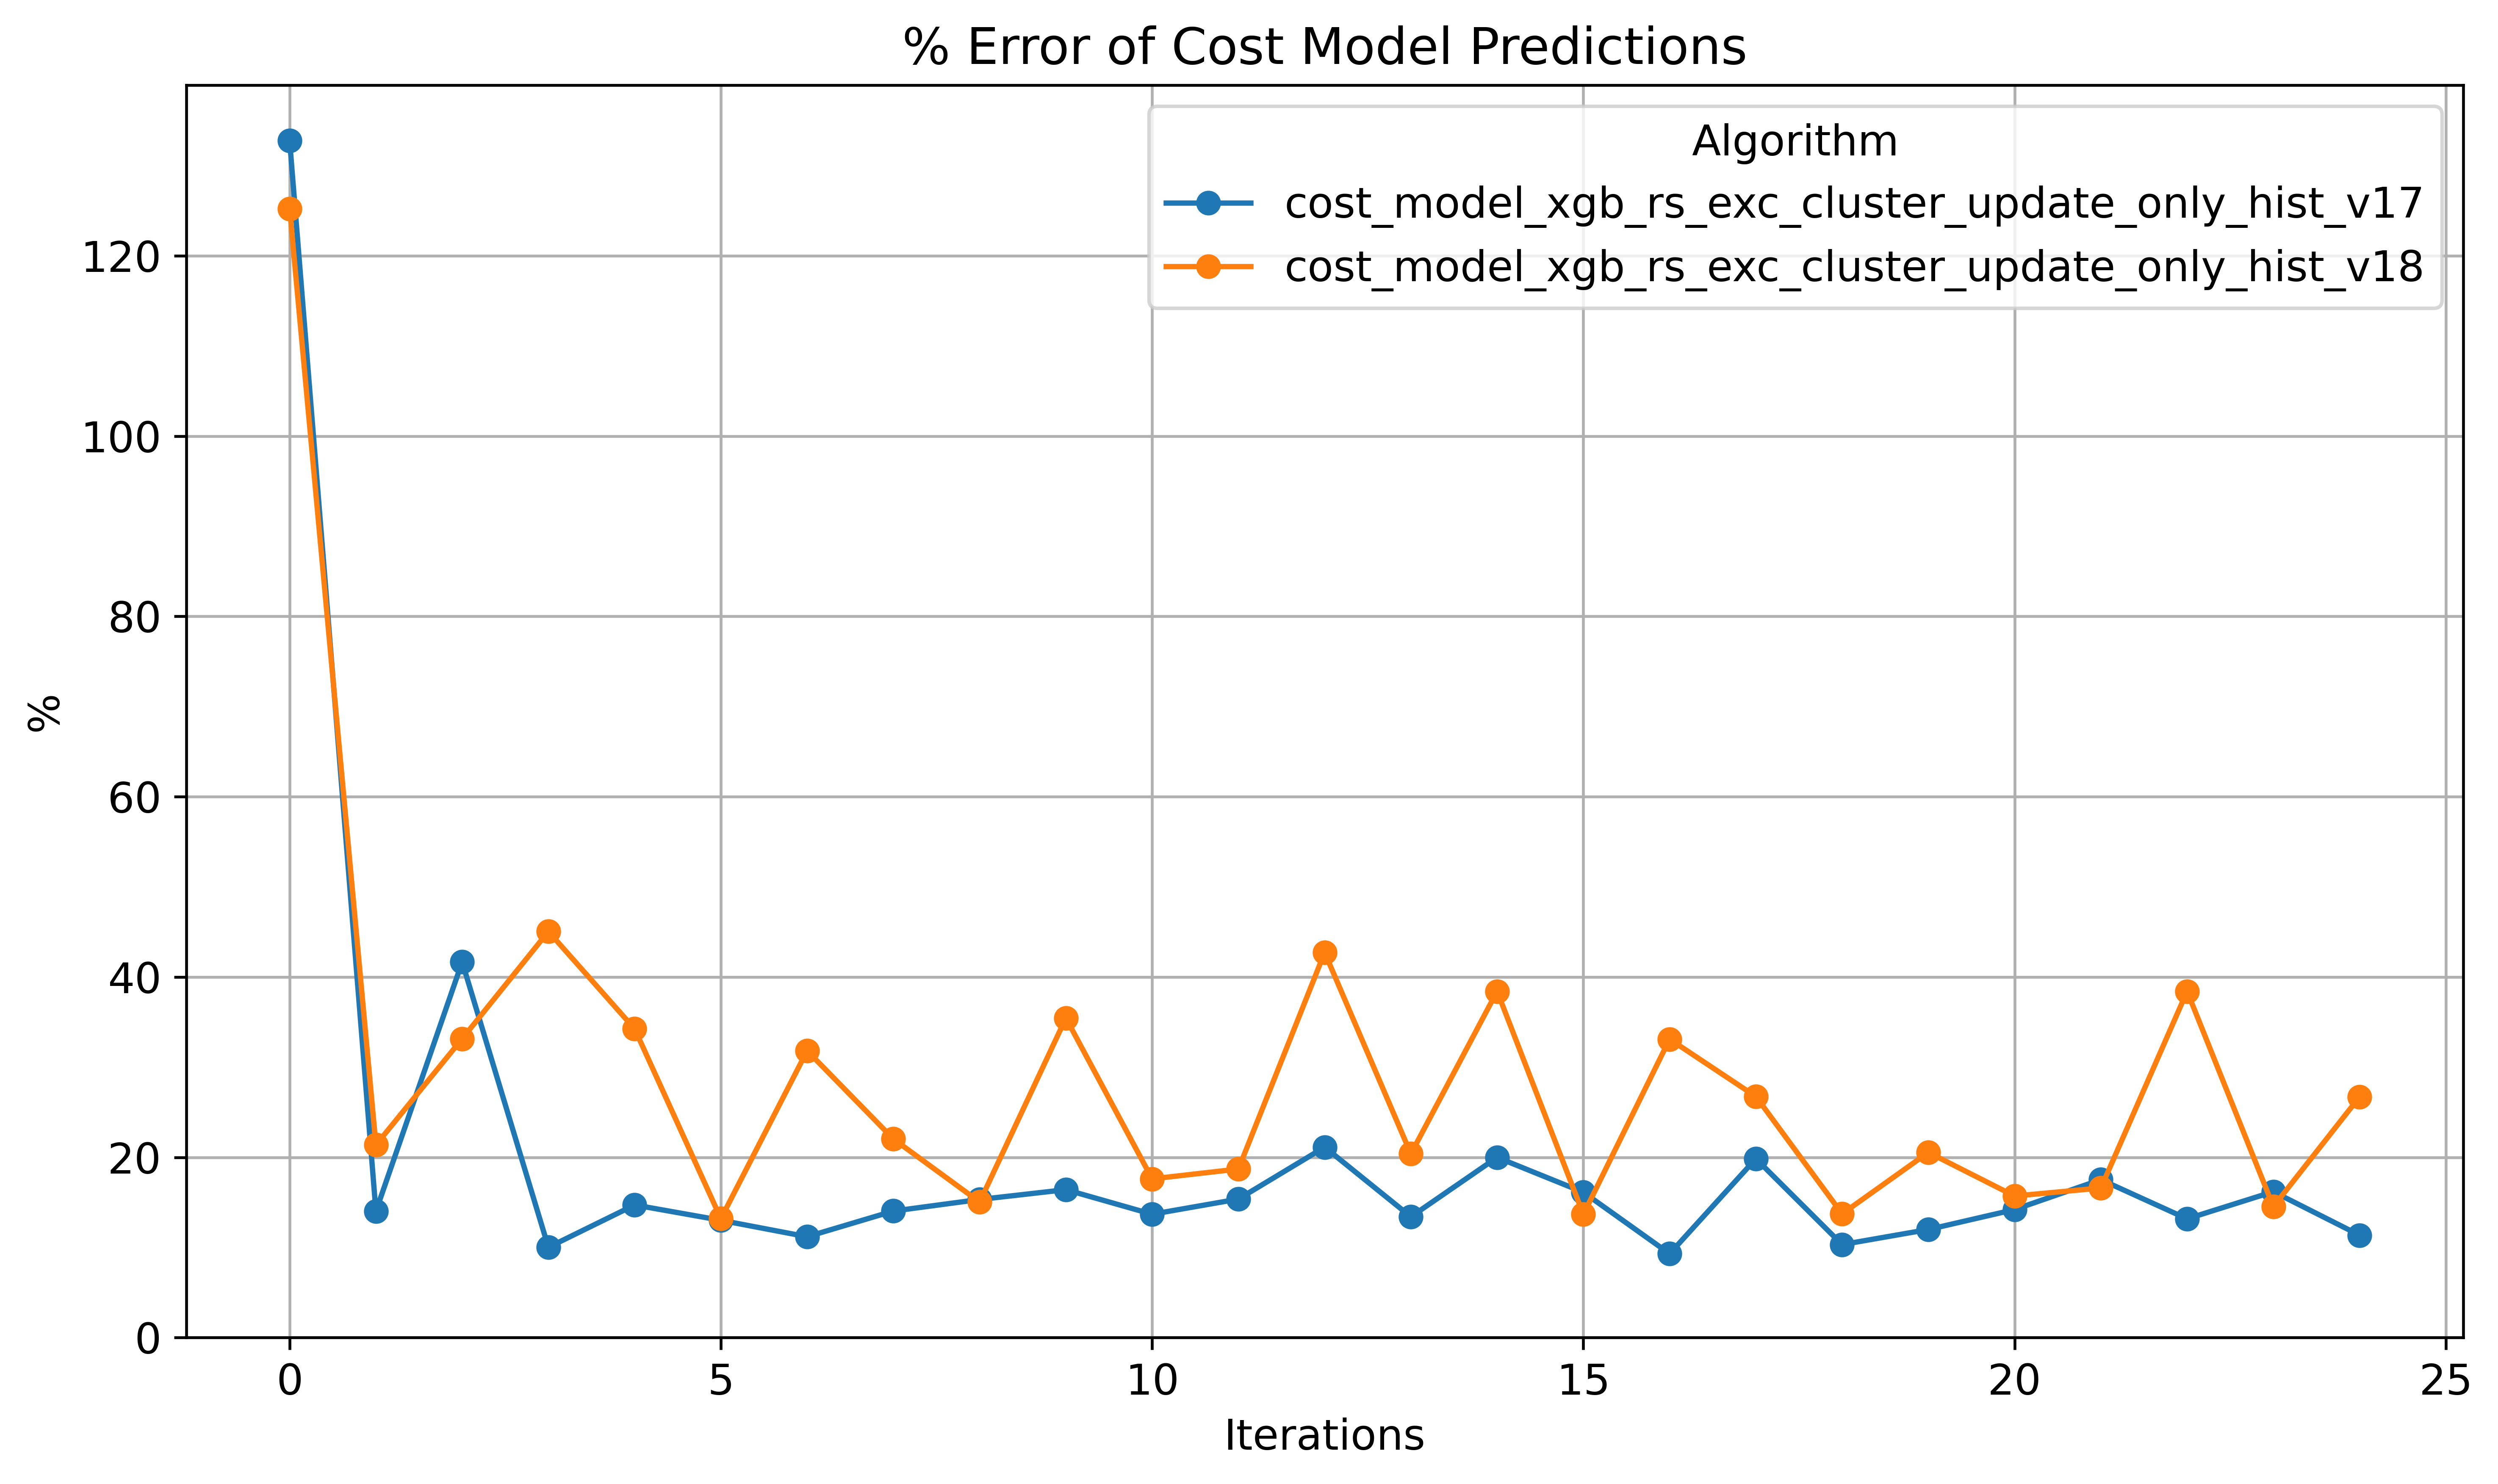

In [1479]:
#file_list = glob.glob('C:/Users/bened/Desktop/Uni/repos/xdbc-client/experiments/model_optimizer/results_1310k/*/cost_model*/*.csv')
file_list = glob.glob('C:/Users/bened/Desktop/Uni/repos/xdbc-client/experiments/model_optimizer/results_10_5M*/*/cost*/*.csv')
plt.rcParams['figure.dpi'] = 600
env = ""
algo = ""
grouped_data_algo = {}
for file in file_list:
    try:

        df = pd.read_csv(file)
        df = df[df['transfer_id'] > 0]
    

        env = file.split("/")[-1].split("\\")[-3]
        algoR = file.split("\\")[-2]
        
        #print(algo)
        '''
        if algoR == "cost_model_xgb_rs_exc_cluster_update_only_hist_v3":
            algoR = "cost_model_xgb_rs_exc_cluster_update_only_hist_v3/4"

        elif algoR == "cost_model_xgb_rs_exc_cluster_update_only_hist_v4":
            algoR = "cost_model_xgb_rs_exc_cluster_update_only_hist_v3/4"
            #print(algoR)
        elif algoR == "cost_model_xgb_rs_exc_cluster_update_only_hist_v5":
            algoR = "cost_model_xgb_rs_exc_cluster_update_only_hist_v5"
            
       
        elif algoR == "cost_model_xgb_rs_exc_cluster_update_only_hist_v8":
            algoR = "cost_model_xgb_rs_exc_cluster_update_only_hist_v8"
            
        elif algoR == "cost_model_xgb_rs_exc_cluster_update_only_hist_v9":
            algoR = "cost_model_xgb_rs_exc_cluster_update_only_hist_v9"
            
        elif algoR == "cost_model_xgb_rs_exc_cluster_update_only_hist_v10":
            algoR = "cost_model_xgb_rs_exc_cluster_update_only_hist_v10"

        
        elif algoR == "cost_model_xgb_rs_exc_cluster_update_only_hist_v11":
            algoR = "cost_model_xgb_rs_exc_cluster_update_only_hist_v11"
            
        elif algoR == "cost_model_xgb_rs_exc_cluster_update_only_hist_v12":
            algoR = "cost_model_xgb_rs_exc_cluster_update_only_hist_v12"
            
        elif algoR == "cost_model_xgb_rs_exc_cluster_update_only_hist_v13":
            algoR = "cost_model_xgb_rs_exc_cluster_update_only_hist_v13"

        elif algoR == "cost_model_xgb_rs_exc_cluster_update_only_hist_v14":
            algoR = "cost_model_xgb_rs_exc_cluster_update_only_hist_v14"

        elif algoR == "cost_model_xgb_rs_exc_cluster_update_only_hist_v15":
            algoR = "cost_model_xgb_rs_exc_cluster_update_only_hist_v15"

        elif algoR == "cost_model_xgb_rs_exc_cluster_update_only_hist_v16":
            algoR = "cost_model_xgb_rs_exc_cluster_update_only_hist_v16"
        '''
        
        if algoR == "cost_model_xgb_rs_exc_cluster_update_only_hist_v17":
            algoR = "cost_model_xgb_rs_exc_cluster_update_only_hist_v17"

        
        elif algoR == "cost_model_xgb_rs_exc_cluster_update_only_hist_v18":
            algoR = "cost_model_xgb_rs_exc_cluster_update_only_hist_v18"
        else:
            continue
        
        #squared_error_series = (df['uncompressed_throughput'] - df['predicted_metric']) ** 2
        squared_error_series = (abs(df['uncompressed_throughput'] - df['predicted_metric']) / df['uncompressed_throughput']) * 100
        
        squared_error_series = squared_error_series.reset_index(drop=True)
        
        if algoR in grouped_data_algo:
            grouped_data_algo[algoR].append(squared_error_series)
        else:
            grouped_data_algo[algoR] = [squared_error_series]

    
    except Exception as e:
        print(f"Error processing file {file}: {e}")

averaged_series_algo = {}

for algo, series_list in grouped_data_algo.items():
    combined_df = pd.concat(series_list, axis=1)
    averaged_series_algo[algo] = combined_df.mean(axis=1)

#print(averaged_series_algo)

plt.figure(figsize=(10, 6))
for algo, series in averaged_series_algo.items():
    plt.plot(series.index, series, marker='o', linestyle='-', label=algo)

plt.xlabel("Iterations")
plt.ylabel("%")
plt.title("% Error of Cost Model Predictions")
plt.legend(title="Algorithm", loc='best')
plt.grid(True)
plt.ylim(bottom=0)
plt.tight_layout()
plt.show()
#plt.savefig("%_Error_of_Cost_Model_Predictions.png",dpi=1200)

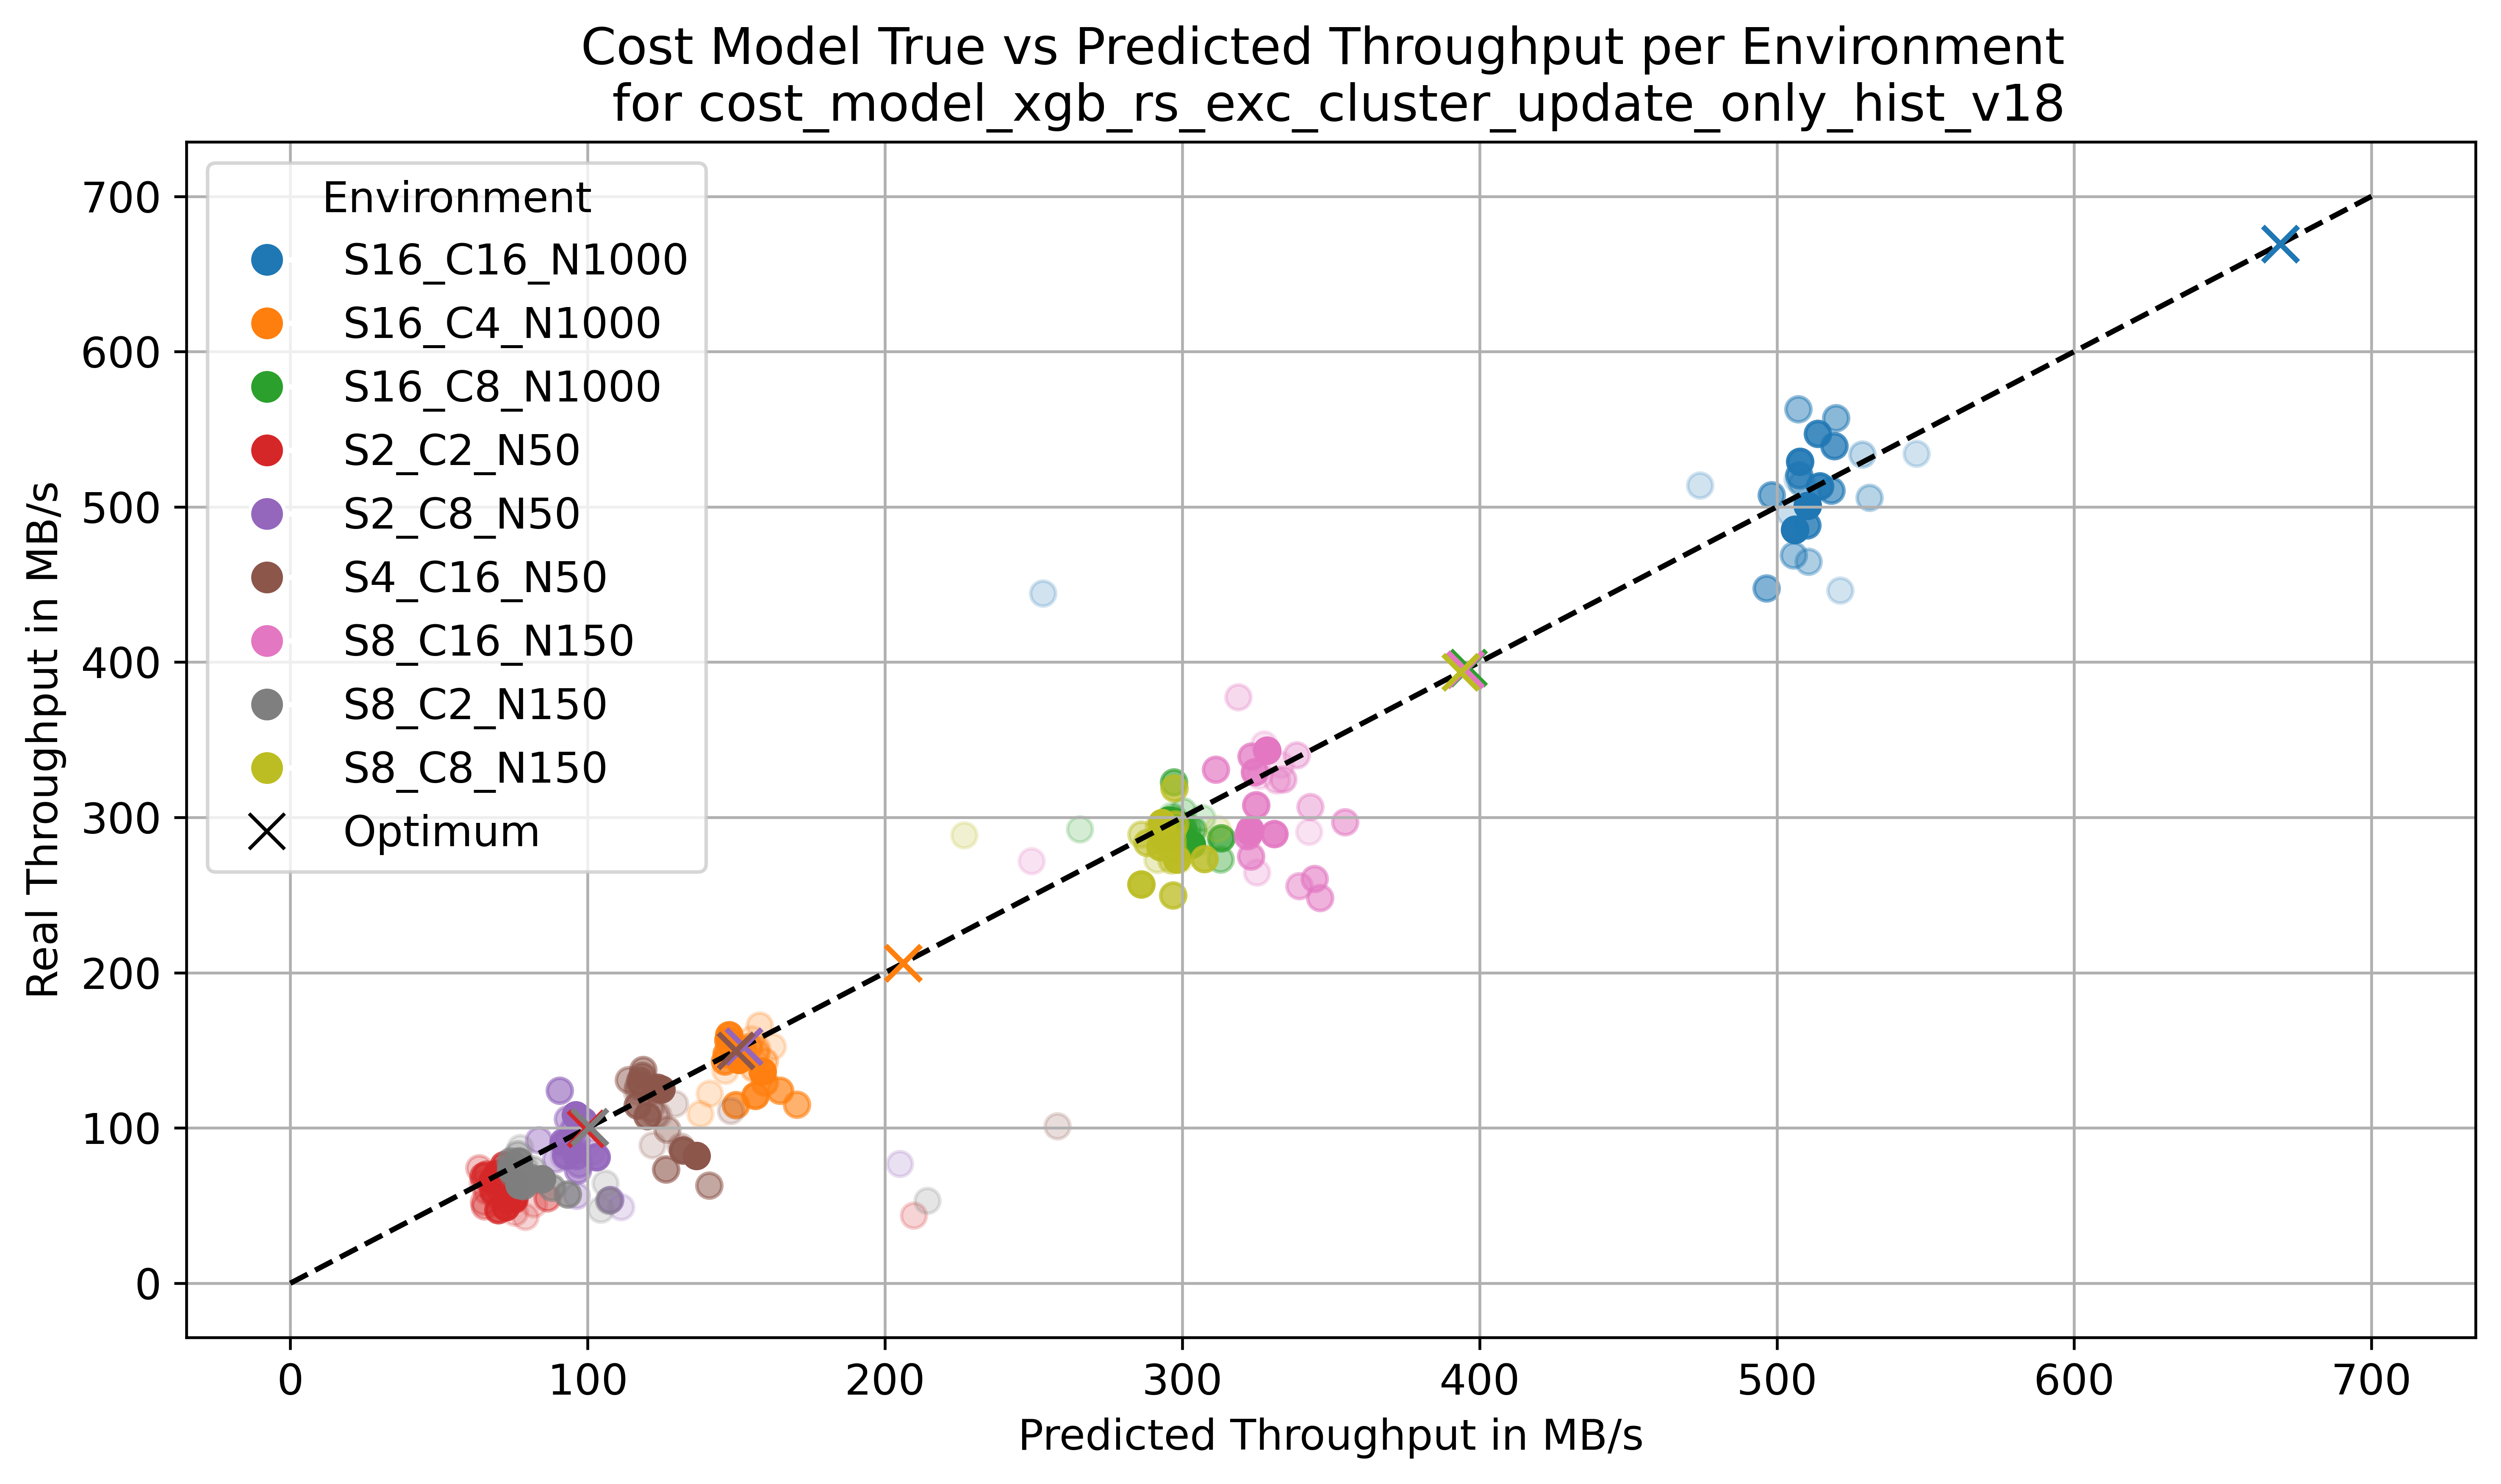

In [1471]:
import yaml
import glob
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
#file_list = glob.glob('C:/Users/bened/Desktop/Uni/repos/xdbc-client/experiments/model_optimizer/results_1310k/*/cost_model*/*.csv')
file_list = glob.glob('C:/Users/bened/Desktop/Uni/repos/xdbc-client/experiments/model_optimizer/results_10_5M*/*/*/*.csv')
plt.rcParams['figure.dpi'] = 600

#algo_to_view = "cost_model_xgb_rs_exc_cluster_update_net_trans"
#algo_to_view = "cost_model_xgb_rs_exc_cluster_update_only_hist"
#algo_to_view = "cost_model_xgb_rs_exc_cluster_update_only_hist_v2"
#algo_to_view = "cost_model_xgb_rs_exc_cluster_update_only_hist_v3/4"
#algo_to_view = "cost_model_xgb_rs_exc_cluster_update_only_hist_v5"
#algo_to_view = "cost_model_xgb_rs_exc_cluster_update_only_hist_v6"
#algo_to_view = "cost_model_xgb_rs_exc_cluster_update_only_hist_v7"
#algo_to_view = "cost_model_xgb_rs_exc_cluster_update_only_hist_v8"
#algo_to_view = "cost_model_xgb_rs_exc_cluster_update_only_hist_v9"
#algo_to_view = "cost_model_xgb_rs_exc_cluster_update_only_hist_v10"
#algo_to_view = "cost_model_xgb_rs_exc_cluster_update_only_hist_v11"
#algo_to_view = "cost_model_xgb_rs_exc_cluster_update_only_hist_v12"
#algo_to_view = "cost_model_xgb_rs_exc_cluster_update_only_hist_v13"
#algo_to_view = "cost_model_xgb_rs_exc_cluster_update_only_hist_v14"
#algo_to_view = "cost_model_xgb_rs_exc_cluster_update_only_hist_v15"
#algo_to_view = "cost_model_xgb_rs_exc_cluster_update_only_hist_v16"
#algo_to_view = "cost_model_xgb_rs_exc_cluster_update_only_hist_v17"
algo_to_view = "cost_model_xgb_rs_exc_cluster_update_only_hist_v18"



env = ""
algo = ""
grouped_data_algo = {}
for file in file_list:
    try:

        df = pd.read_csv(file)
        df = df[df['transfer_id'] > 0]
    

        env = file.split("/")[-1].split("\\")[-3]
        algo = file.split("\\")[-2]
        '''
        if "cost_model_xgb_rs_exc_cluster_update_only_hist" in algo:
            algo = "cost_model_xgb_rs_exc_cluster_update_only_hist"
        else:
             continue
        '''
        #if algo == "cost_model_xgb_rs_exc_cluster_update_only_hist_v13":
        #    algo = "cost_model_xgb_rs_exc_cluster_update_only_hist_v14"

        if algo != algo_to_view:
            continue
        
        algo = env#+ "_" + algo
        
         # Group by algorithm
        if algo in grouped_data_algo:
            grouped_data_algo[algo].append(df[['uncompressed_throughput', 'predicted_metric']].reset_index(drop=True))
        else:
            grouped_data_algo[algo] = [df[['uncompressed_throughput', 'predicted_metric']].reset_index(drop=True)]


    
    except Exception as e:
        print(f"Error processing file {file}: {e}")



averaged_points_algo = {}

for algo, df_list in grouped_data_algo.items():
    avg_time = pd.concat([df['uncompressed_throughput'] for df in df_list], axis=1).mean(axis=1)    
    avg_pred_time = pd.concat([df['predicted_metric'] for df in df_list], axis=1).mean(axis=1)    
    averaged_df = pd.DataFrame({'uncompressed_throughput': avg_time, 'predicted_metric': avg_pred_time})    
    averaged_points_algo[algo] = averaged_df

plt.rcParams.update({'font.size'   : 12})
plt.figure(figsize=(10, 6))

default_colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
algo_colors = {}
for i, algo in enumerate(averaged_points_algo.keys()):
    algo_colors[algo] = default_colors[i % len(default_colors)]

for algo, df in averaged_points_algo.items():
    num_rows = len(df)
    for i in range(num_rows):
        # Increase alpha: earlier points are more transparent.
        alpha_val = min(1,max((i + 1) / num_rows,0.2))
        plt.scatter(
            df['predicted_metric'].iloc[i],
            df['uncompressed_throughput'].iloc[i],
            color=algo_colors[algo],
            alpha=alpha_val,
            label=algo if i == 0 else "",
            s=50
        )
        
best_throughputsxx = { # from everything
"S16_C16_N1000": 672,
"S16_C4_N1000": 217,
"S16_C8_N1000": 419,    
    
"S2_C2_N50": 101,
"S2_C8_N50": 151,
"S4_C16_N50": 153,    
    
"S8_C16_N150": 396,
"S8_C2_N150": 103,
"S8_C8_N150": 394,
}

best_throughputs = { # from opt runs from the same search space
"S16_C16_N1000": 669.33,
"S16_C4_N1000": 206.18,
"S16_C8_N1000": 396.21,  
    
"S2_C2_N50": 99.49,
"S2_C8_N50": 152.57,
"S4_C16_N50": 149.82,  
    
"S8_C16_N150": 395.26,
"S8_C2_N150": 100.69,
"S8_C8_N150": 393.64,
}

best_throughputsXX = { # from random samples
        "S16_C16_N1000": 611.88, #16 16 1000
        "S16_C4_N1000": 205.34, # 16 4 1000
        "S16_C8_N1000":  357.95, # 16 8 1000    
        "S2_C2_N50":89.13, #2 2 50
        "S2_C8_N50":141.07, # 2 8 50
        "S4_C16_N50":149.16, # 4 16 50        
        "S8_C8_N150": 312.92, # 8 8 150
        "S8_C2_N150":87.12, #8 2 150
        "S8_C16_N150": 373.59, #8 16 150
}

max_time = max(
    max(df['uncompressed_throughput'].max(), df['predicted_metric'].max())
    for df in [df_algo for df_list in averaged_points_algo.values() for df_algo in [df_list]]
)
plt.plot([0, 700], [0, 700], color='black', linestyle='--')

custom_handles = []
for algo, color in algo_colors.items():
    #plt.plot((0, best_throughputs[algo]), (best_throughputs[algo], best_throughputs[algo]), color=color, linestyle='--')   
    plt.scatter(best_throughputs[algo], best_throughputs[algo], color=color, marker='x', s=100, zorder=5) 
    handle = Line2D([0], [0], marker='o', color='w', label=algo,
                    markerfacecolor=color, markersize=10)
    custom_handles.append(handle)


optimum_handle = Line2D([0,0],[0,0], marker='x', color='black', linestyle='None',
markersize=10, label='Optimum')
custom_handles.append(optimum_handle)

plt.legend(handles=custom_handles, title="Environment", loc="upper left")

plt.xlabel("Predicted Throughput in MB/s")
plt.ylabel("Real Throughput in MB/s")

plt.title(f"Cost Model True vs Predicted Throughput per Environment \n for {algo_to_view}")

plt.grid(True)
plt.tight_layout()
plt.show()

#plt.savefig(f"True_vs_Predicted_Throughput_per_Environment_for_{algo_to_view}.png", dpi=1200)

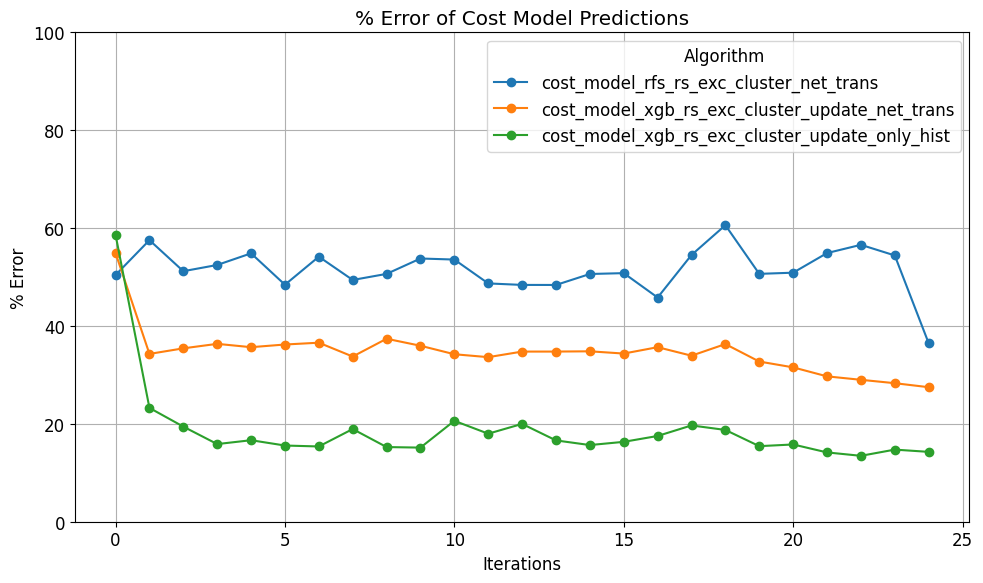

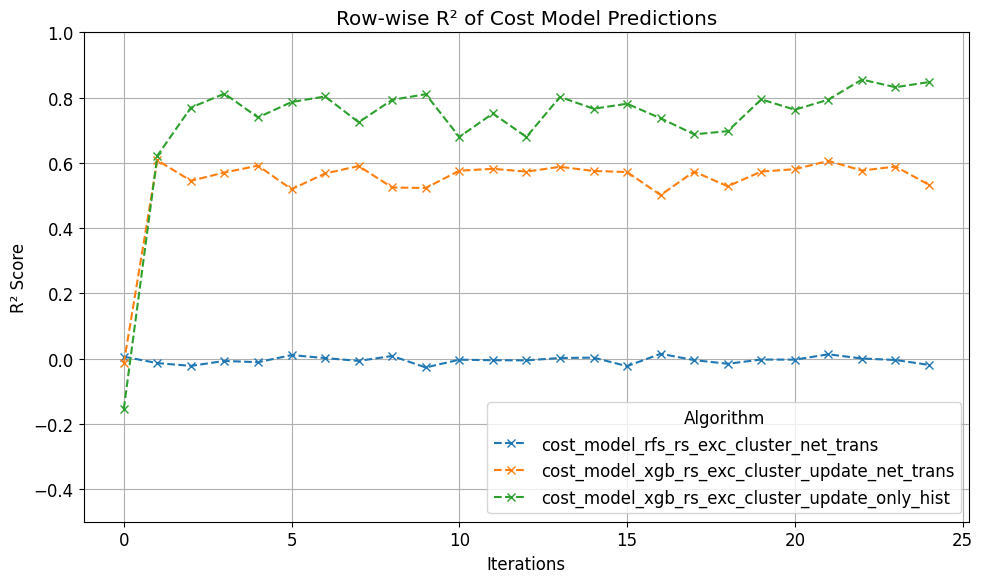

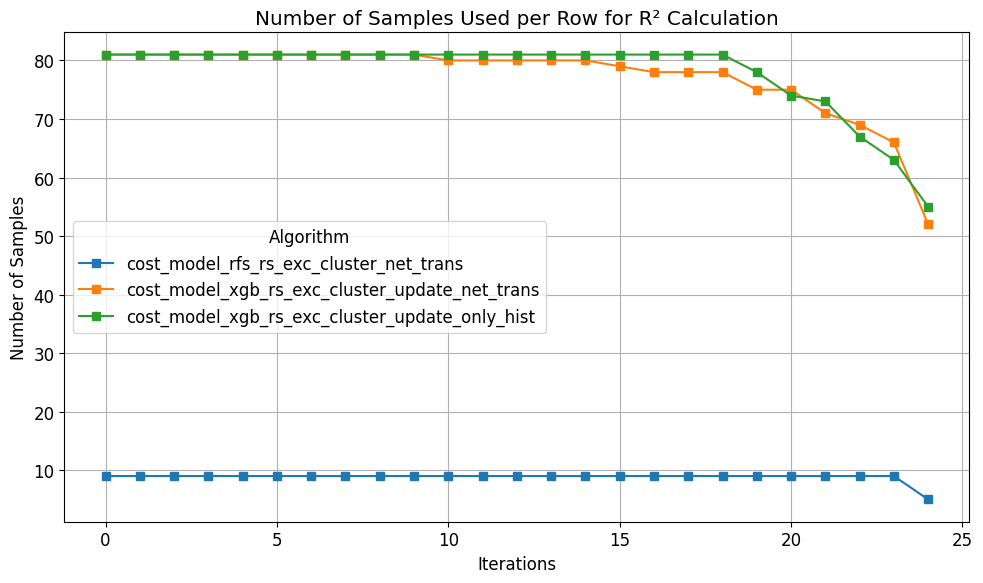

In [87]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

file_list = glob.glob('C:/Users/bened/Desktop/Uni/repos/xdbc-client/experiments/model_optimizer/results_1310k/*/cost_model*/*.csv')

env = ""
algo = ""
grouped_data_algo = {}
grouped_data_algo_times = {}

for file in file_list:
    try:
        df = pd.read_csv(file)
        df = df[df['transfer_id'] > 0]

        # Extract environment and algorithm from the file path
        env = file.split("/")[-1].split("\\")[-3]
        algo = file.split("\\")[-2]

        # Normalize algorithm names for grouping
        if "cost_model_xgb_rs_exc_cluster_update_net_trans" in algo:
            algo = "cost_model_xgb_rs_exc_cluster_update_net_trans"
        elif "cost_model_xgb_rs_exc_cluster_update_only_hist" in algo:
            algo = "cost_model_xgb_rs_exc_cluster_update_only_hist"
        elif algo == "cost_model_rfs_rs_exc_cluster_net_trans":
            algo = "cost_model_rfs_rs_exc_cluster_net_trans"
        else:
            continue

        # Calculate percentage error for each row
        error_series = (abs(df['time'] - df['predicted_time']) / df['time']) * 100
        error_series = error_series.reset_index(drop=True)

        if algo in grouped_data_algo:
            grouped_data_algo[algo].append(error_series)
        else:
            grouped_data_algo[algo] = [error_series]

        # Store raw actual and predicted time values for R² calculation
        df_times = df[['time', 'predicted_time']].reset_index(drop=True)
        if algo in grouped_data_algo_times:
            grouped_data_algo_times[algo].append(df_times)
        else:
            grouped_data_algo_times[algo] = [df_times]

    except Exception as e:
        print(f"Error processing file {file}: {e}")





# Compute row-wise R² and sample counts for each algorithm
row_wise_r2_scores = {}
row_sample_counts = {}
for algo, df_list in grouped_data_algo_times.items():
    # Combine all DataFrames for this algorithm row-wise
    combined_df = pd.concat(df_list, axis=1)
    # Count non-NaN values per row (number of samples contributing to R²)
    sample_counts_per_row = combined_df.notna().sum(axis=1) // 2  # Divide by 2 since columns alternate between actual and predicted
    row_sample_counts[algo] = sample_counts_per_row
    # Fill NaN values with column means to ensure full-length R² calculation
    combined_df_filled = combined_df.fillna(combined_df.mean())
    # Compute row-wise R² scores
    r2_scores_per_row = combined_df_filled.apply(
        lambda row: r2_score(row.iloc[::2], row.iloc[1::2]) if len(row.dropna()) > 1 else None,
        axis=1
    )
    row_wise_r2_scores[algo] = r2_scores_per_row





# Compute the row-wise averaged percentage error for each algorithm
averaged_series_algo = {}
for algo, series_list in grouped_data_algo.items():
    combined_df = pd.concat(series_list, axis=1)
    averaged_series_algo[algo] = combined_df.mean(axis=1)




# Plot percentage error (% Error) in a separate plot
plt.figure(figsize=(10, 6))
for algo, series in averaged_series_algo.items():
    plt.plot(series.index, series, marker='o', linestyle='-', label=algo)
plt.xlabel("Iterations")
plt.ylabel("% Error")
plt.title("% Error of Cost Model Predictions")
plt.legend(title="Algorithm", loc='best')
plt.grid(True)
plt.ylim(bottom=0, top=100)
plt.tight_layout()
plt.show()





# Plot R² scores in a separate plot
plt.figure(figsize=(10, 6))
for algo, r2_scores in row_wise_r2_scores.items():
    plt.plot(r2_scores.index, r2_scores.values, marker='x', linestyle='--', label=algo)
plt.xlabel("Iterations")
plt.ylabel("R² Score")
plt.title("Row-wise R² of Cost Model Predictions")
plt.legend(title="Algorithm", loc='best')
plt.grid(True)
plt.ylim(bottom=-0.5, top=1.0)  # Adjust limits based on expected R² range
plt.tight_layout()
plt.show()





# Plot number of samples per row in a separate plot
plt.figure(figsize=(10, 6))
for algo, sample_counts in row_sample_counts.items():
    plt.plot(sample_counts.index, sample_counts.values, marker='s', linestyle='-', label=algo)
plt.xlabel("Iterations")
plt.ylabel("Number of Samples")
plt.title("Number of Samples Used per Row for R² Calculation")
plt.legend(title="Algorithm", loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()


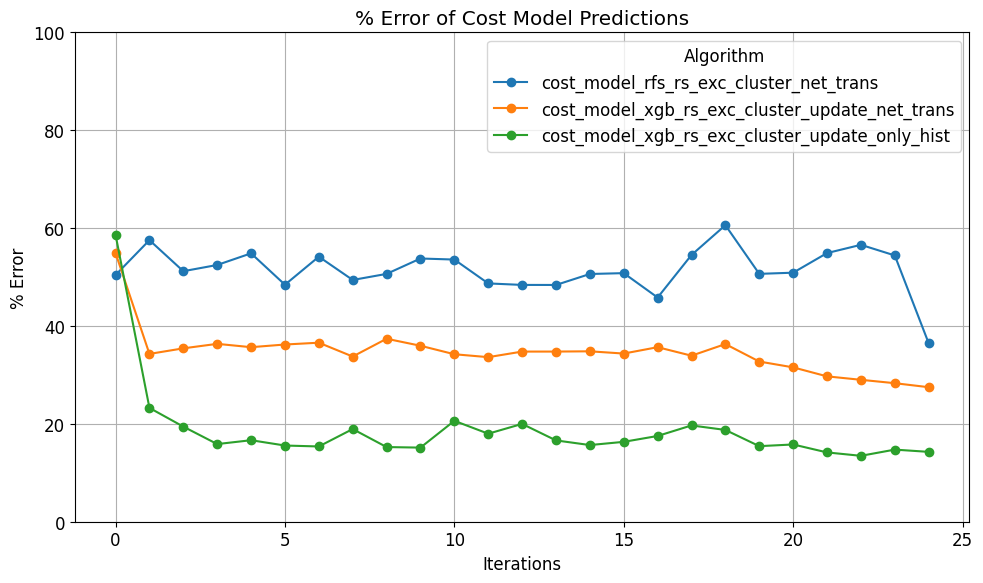

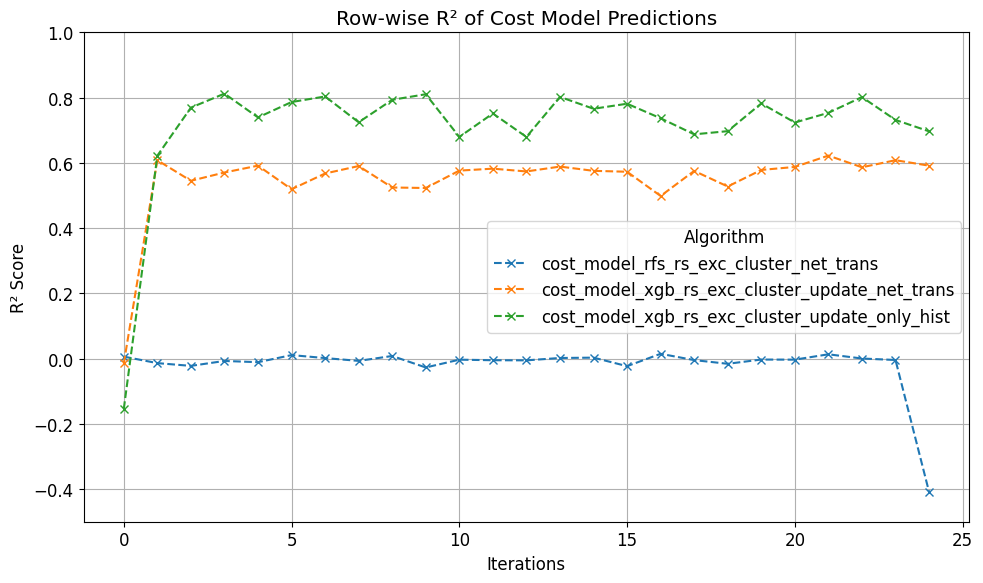

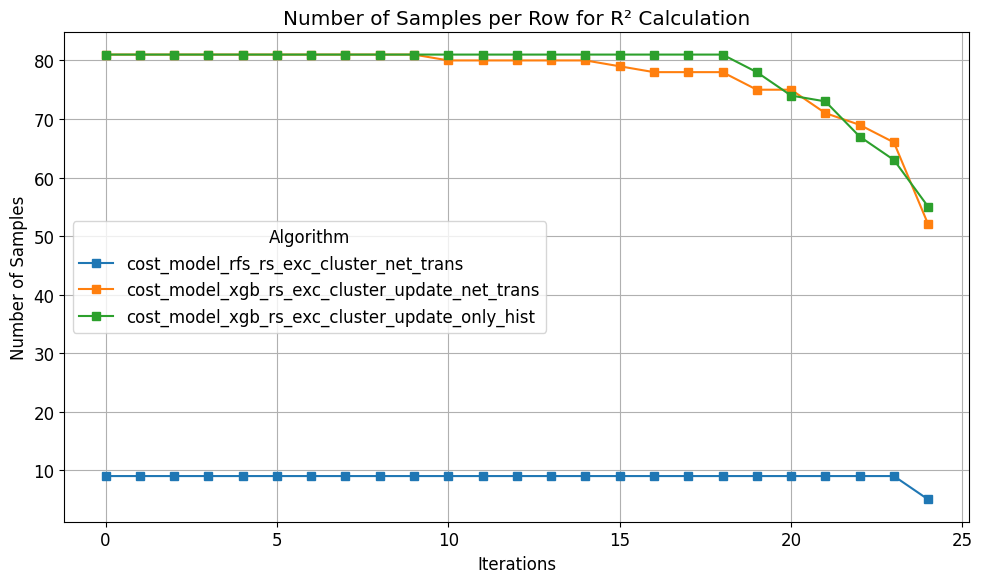

In [85]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# --- Data Loading & Grouping ---

file_list = glob.glob(
    'C:/Users/bened/Desktop/Uni/repos/xdbc-client/experiments/model_optimizer/results_1310k/*/cost_model*/*.csv'
)

grouped_data_algo = {}
grouped_data_algo_times = {}

for file in file_list:
    try:
        df = pd.read_csv(file)
        df = df[df['transfer_id'] > 0]

        # Extract environment and algorithm from the file path
        env = file.split("/")[-1].split("\\")[-3]
        algo = file.split("\\")[-2]

        # Normalize algorithm names for grouping
        if "cost_model_xgb_rs_exc_cluster_update_net_trans" in algo:
            algo = "cost_model_xgb_rs_exc_cluster_update_net_trans"
        elif "cost_model_xgb_rs_exc_cluster_update_only_hist" in algo:
            algo = "cost_model_xgb_rs_exc_cluster_update_only_hist"
        elif algo == "cost_model_rfs_rs_exc_cluster_net_trans":
            algo = "cost_model_rfs_rs_exc_cluster_net_trans"
        else:
            continue

        # Calculate percentage error for each row
        error_series = (abs(df['time'] - df['predicted_time']) / df['time']) * 100
        error_series = error_series.reset_index(drop=True)
        grouped_data_algo.setdefault(algo, []).append(error_series)

        # Store raw actual and predicted time values for R² calculation.
        # We only keep the two columns and reset their index.
        df_times = df[['time', 'predicted_time']].reset_index(drop=True)
        grouped_data_algo_times.setdefault(algo, []).append(df_times)

    except Exception as e:
        print(f"Error processing file {file}: {e}")

# --- Row-wise R² and Sample Count Calculation Using Actual Column Names ---

row_wise_r2_scores = {}
row_sample_counts = {}

for algo, df_list in grouped_data_algo_times.items():
    # Concatenate the DataFrames with keys so that the resulting DataFrame has a MultiIndex.
    # The new level (level 0) will indicate the file index, while level 1 preserves the original column names.
    combined_df = pd.concat(df_list, axis=1, keys=range(len(df_list)))
    
    # Define a function that computes R² for a given row by separating values using the actual column names.
    def compute_row_r2(row):
        # Extract values from the 'time' columns and 'predicted_time' columns using their names.
        y_true = row.xs('time', axis=0, level=1)
        y_pred = row.xs('predicted_time', axis=0, level=1)
        if y_true.notna().sum() < 2:
            return None  # Not enough observations to compute R²
        # Optionally fill NaN values in each extracted series with its mean
        y_true_filled = y_true.fillna(y_true.mean())
        y_pred_filled = y_pred.fillna(y_pred.mean())
        return r2_score(y_true_filled.values, y_pred_filled.values)
    
    # Compute R² score row by row using the actual column names.
    r2_scores_per_row = combined_df.apply(compute_row_r2, axis=1)
    row_wise_r2_scores[algo] = r2_scores_per_row
    
    # Compute how many samples (i.e. non-NaN 'time' values) were present per row.
    sample_counts_per_row = combined_df.apply(
        lambda row: row.xs('time', axis=0, level=1).notna().sum(), axis=1)
    row_sample_counts[algo] = sample_counts_per_row

# --- Averaging the Percentage Error Series ---

averaged_series_algo = {}
for algo, series_list in grouped_data_algo.items():
    combined_err_df = pd.concat(series_list, axis=1)
    averaged_series_algo[algo] = combined_err_df.mean(axis=1)

# --- Plot 1: Averaged Percentage Error ---

plt.figure(figsize=(10, 6))
for algo, series in averaged_series_algo.items():
    plt.plot(series.index, series, marker='o', linestyle='-', label=algo)
plt.xlabel("Iterations")
plt.ylabel("% Error")
plt.title("% Error of Cost Model Predictions")
plt.legend(title="Algorithm", loc='best')
plt.grid(True)
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

# --- Plot 2: Row-wise R² Scores ---

plt.figure(figsize=(10, 6))
for algo, r2_scores in row_wise_r2_scores.items():
    plt.plot(r2_scores.index, r2_scores.values, marker='x', linestyle='--', label=algo)
plt.xlabel("Iterations")
plt.ylabel("R² Score")
plt.title("Row-wise R² of Cost Model Predictions")
plt.legend(title="Algorithm", loc='best')
plt.grid(True)
plt.ylim(-0.5, 1.0)  # Adjust limits as needed based on your data
plt.tight_layout()
plt.show()

# --- Plot 3: Number of Samples per Row Used for R² Calculation ---

plt.figure(figsize=(10, 6))
for algo, sample_counts in row_sample_counts.items():
    plt.plot(sample_counts.index, sample_counts.values, marker='s', linestyle='-', label=algo)
plt.xlabel("Iterations")
plt.ylabel("Number of Samples")
plt.title("Number of Samples per Row for R² Calculation")
plt.legend(title="Algorithm", loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()
